In [1]:
# =============================================================================
# SETUP AND IMPORTS
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# =============================================================================
# 1. β-VAE MODEL IMPLEMENTATION
# =============================================================================

class BetaVAE(nn.Module):
    def __init__(self, latent_dim=2, beta=1.0):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 128x4x4
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 256x2x2
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the size after convolutions
        self.encoder_output_size = 256 * 2 * 2  # 1024

        # Latent space
        self.fc_mu = nn.Linear(self.encoder_output_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_size, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.encoder_output_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 128x4x4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # 3x32x32
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 2, 2)  # Reshape to match encoder output
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss (Binary Cross Entropy)
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

        # KL divergence
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss
        loss = BCE + self.beta * KLD
        return loss, BCE, KLD

In [3]:
# =============================================================================
# 2. DATA LOADING AND PREPROCESSING
# =============================================================================

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])


In [4]:
# =============================================================================
# 3. TRAINING FUNCTION
# =============================================================================

def train_vae(model, train_loader, test_loader, epochs=50, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_bce = 0
        total_kld = 0

        # Training phase
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)
            loss, bce, kld = model.loss_function(recon_batch, data, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()

        # Calculate average losses
        avg_loss = total_loss / len(train_loader.dataset)
        avg_bce = total_bce / len(train_loader.dataset)
        avg_kld = total_kld / len(train_loader.dataset)
        train_losses.append((avg_loss, avg_bce, avg_kld))

        # Validation phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = model.loss_function(recon_batch, data, mu, logvar)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f} (BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}), "
              f"Test Loss = {avg_test_loss:.4f}")

    return train_losses, test_losses

In [5]:
# =============================================================================
# 4. VISUALIZATION FUNCTIONS
# =============================================================================

def plot_reconstructions(model, test_loader, num_images=10):
    """Plot original images and their reconstructions"""
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        data_iter = iter(test_loader)
        images, _ = next(data_iter)
        images = images[:num_images].to(device)

        # Get reconstructions
        reconstructions, _, _ = model(images)

        # Plot
        fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

        for i in range(num_images):
            # Original images
            axes[0, i].imshow(images[i].cpu().permute(1, 2, 0))
            axes[0, i].set_title(f"Original {i+1}")
            axes[0, i].axis('off')

            # Reconstructed images
            axes[1, i].imshow(reconstructions[i].cpu().permute(1, 2, 0))
            axes[1, i].set_title(f"Reconstructed {i+1}")
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

def plot_latent_space_grid(model, grid_size=12, latent_dim=100):
    """Plot a grid of generated images from latent space"""
    model.eval()
    with torch.no_grad():
        # Create a grid in latent space
        z = torch.randn(grid_size * grid_size, latent_dim).to(device)
        generated_images = model.decode(z)

        # Plot grid
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i].cpu().permute(1, 2, 0))
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_training_loss(train_losses, test_losses):
    """Plot training and test losses"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Total loss
    train_total = [loss[0] for loss in train_losses]
    ax1.plot(train_total, label='Train Loss')
    ax1.plot(test_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Total Loss')
    ax1.legend()
    ax1.grid(True)

    # Components
    train_bce = [loss[1] for loss in train_losses]
    train_kld = [loss[2] for loss in train_losses]
    ax2.plot(train_bce, label='Reconstruction Loss (BCE)')
    ax2.plot(train_kld, label='KL Divergence')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss Components')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

QUESTION 1A: Latent Dimension = 2
Model initialized with latent dimension: 2
Training model with latent dimension 2...


Epoch 1/30: 100%|██████████| 391/391 [00:12<00:00, 30.49it/s]


Epoch 1: Train Loss = 1976.8530 (BCE: 1971.9680, KLD: 4.8850), Test Loss = 1958.7198


Epoch 2/30: 100%|██████████| 391/391 [00:11<00:00, 35.37it/s]


Epoch 2: Train Loss = 1955.7001 (BCE: 1950.5396, KLD: 5.1605), Test Loss = 1956.3990


Epoch 3/30: 100%|██████████| 391/391 [00:11<00:00, 35.12it/s]


Epoch 3: Train Loss = 1954.0437 (BCE: 1948.7264, KLD: 5.3173), Test Loss = 1956.3080


Epoch 4/30: 100%|██████████| 391/391 [00:10<00:00, 35.97it/s]


Epoch 4: Train Loss = 1952.7286 (BCE: 1947.2522, KLD: 5.4764), Test Loss = 1954.1449


Epoch 5/30: 100%|██████████| 391/391 [00:10<00:00, 36.35it/s]


Epoch 5: Train Loss = 1952.1184 (BCE: 1946.4996, KLD: 5.6188), Test Loss = 1953.5605


Epoch 6/30: 100%|██████████| 391/391 [00:10<00:00, 36.21it/s]


Epoch 6: Train Loss = 1951.4479 (BCE: 1945.7168, KLD: 5.7310), Test Loss = 1953.8275


Epoch 7/30: 100%|██████████| 391/391 [00:10<00:00, 36.23it/s]


Epoch 7: Train Loss = 1949.7207 (BCE: 1943.8795, KLD: 5.8412), Test Loss = 1951.9222


Epoch 8/30: 100%|██████████| 391/391 [00:10<00:00, 36.27it/s]


Epoch 8: Train Loss = 1950.7124 (BCE: 1944.8285, KLD: 5.8839), Test Loss = 1970.1294


Epoch 9/30: 100%|██████████| 391/391 [00:10<00:00, 36.15it/s]


Epoch 9: Train Loss = 1950.5217 (BCE: 1944.5996, KLD: 5.9221), Test Loss = 1959.1543


Epoch 10/30: 100%|██████████| 391/391 [00:12<00:00, 32.48it/s]


Epoch 10: Train Loss = 1948.7232 (BCE: 1942.7144, KLD: 6.0087), Test Loss = 1949.1843


Epoch 11/30: 100%|██████████| 391/391 [00:10<00:00, 36.51it/s]


Epoch 11: Train Loss = 1947.4920 (BCE: 1941.4693, KLD: 6.0227), Test Loss = 1951.8550


Epoch 12/30: 100%|██████████| 391/391 [00:10<00:00, 37.06it/s]


Epoch 12: Train Loss = 1948.0468 (BCE: 1941.9349, KLD: 6.1119), Test Loss = 1949.9042


Epoch 13/30: 100%|██████████| 391/391 [00:10<00:00, 36.28it/s]


Epoch 13: Train Loss = 1948.1661 (BCE: 1942.0594, KLD: 6.1067), Test Loss = 1952.2139


Epoch 14/30: 100%|██████████| 391/391 [00:11<00:00, 33.92it/s]


Epoch 14: Train Loss = 1946.9194 (BCE: 1940.7655, KLD: 6.1539), Test Loss = 1948.8209


Epoch 15/30: 100%|██████████| 391/391 [00:11<00:00, 35.37it/s]


Epoch 15: Train Loss = 1947.1235 (BCE: 1940.9791, KLD: 6.1443), Test Loss = 1947.3610


Epoch 16/30: 100%|██████████| 391/391 [00:14<00:00, 26.75it/s]


Epoch 16: Train Loss = 1946.8595 (BCE: 1940.6969, KLD: 6.1626), Test Loss = 1955.1978


Epoch 17/30: 100%|██████████| 391/391 [00:11<00:00, 35.06it/s]


Epoch 17: Train Loss = 1946.3975 (BCE: 1940.2259, KLD: 6.1716), Test Loss = 1945.6169


Epoch 18/30: 100%|██████████| 391/391 [00:10<00:00, 35.59it/s]


Epoch 18: Train Loss = 1946.4902 (BCE: 1940.2870, KLD: 6.2032), Test Loss = 1944.4386


Epoch 19/30: 100%|██████████| 391/391 [00:10<00:00, 36.29it/s]


Epoch 19: Train Loss = 1944.2295 (BCE: 1938.0347, KLD: 6.1948), Test Loss = 1946.2455


Epoch 20/30: 100%|██████████| 391/391 [00:11<00:00, 34.49it/s]


Epoch 20: Train Loss = 1950.0537 (BCE: 1943.8102, KLD: 6.2435), Test Loss = 1948.6671


Epoch 21/30: 100%|██████████| 391/391 [00:10<00:00, 36.07it/s]


Epoch 21: Train Loss = 1945.6684 (BCE: 1939.4369, KLD: 6.2315), Test Loss = 1945.7768


Epoch 22/30: 100%|██████████| 391/391 [00:11<00:00, 35.45it/s]


Epoch 22: Train Loss = 1944.9671 (BCE: 1938.6809, KLD: 6.2863), Test Loss = 1952.0170


Epoch 23/30: 100%|██████████| 391/391 [00:10<00:00, 35.73it/s]


Epoch 23: Train Loss = 1945.5213 (BCE: 1939.2999, KLD: 6.2214), Test Loss = 1945.5682


Epoch 24/30: 100%|██████████| 391/391 [00:10<00:00, 36.54it/s]


Epoch 24: Train Loss = 1944.8347 (BCE: 1938.6324, KLD: 6.2023), Test Loss = 1946.9775


Epoch 25/30: 100%|██████████| 391/391 [00:10<00:00, 36.29it/s]


Epoch 25: Train Loss = 1944.6999 (BCE: 1938.4336, KLD: 6.2663), Test Loss = 1950.7914


Epoch 26/30: 100%|██████████| 391/391 [00:10<00:00, 36.03it/s]


Epoch 26: Train Loss = 1943.5444 (BCE: 1937.3119, KLD: 6.2325), Test Loss = 1944.4603


Epoch 27/30: 100%|██████████| 391/391 [00:11<00:00, 35.51it/s]


Epoch 27: Train Loss = 1945.7510 (BCE: 1939.3864, KLD: 6.3646), Test Loss = 1964.4278


Epoch 28/30: 100%|██████████| 391/391 [00:11<00:00, 35.43it/s]


Epoch 28: Train Loss = 1950.2256 (BCE: 1943.8912, KLD: 6.3344), Test Loss = 1951.1476


Epoch 29/30: 100%|██████████| 391/391 [00:10<00:00, 36.43it/s]


Epoch 29: Train Loss = 1946.2399 (BCE: 1939.9796, KLD: 6.2604), Test Loss = 1946.9080


Epoch 30/30: 100%|██████████| 391/391 [00:10<00:00, 36.82it/s]


Epoch 30: Train Loss = 1945.1499 (BCE: 1938.8661, KLD: 6.2838), Test Loss = 1947.6531


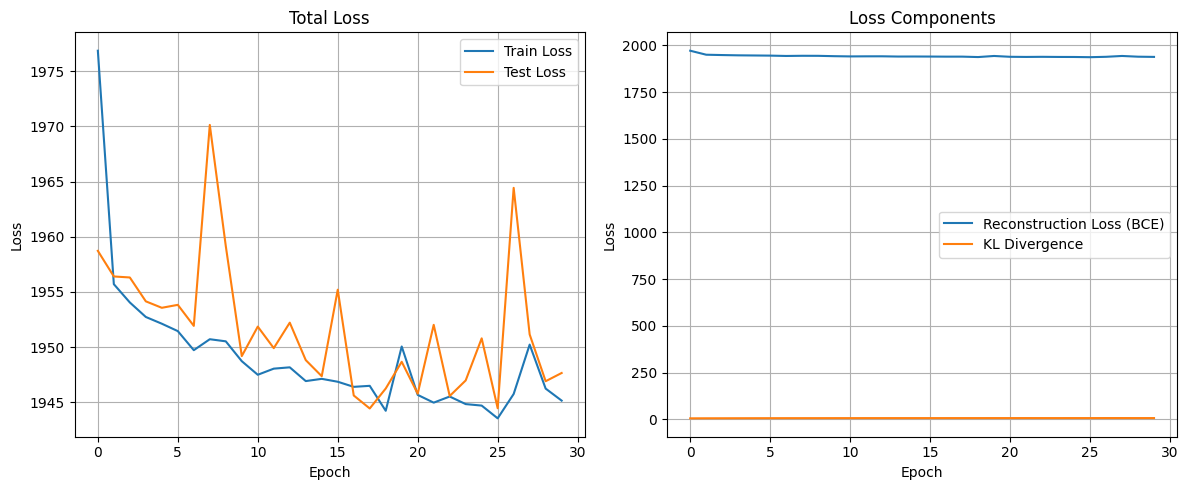


Displaying original vs reconstructed images (latent dim = 2):


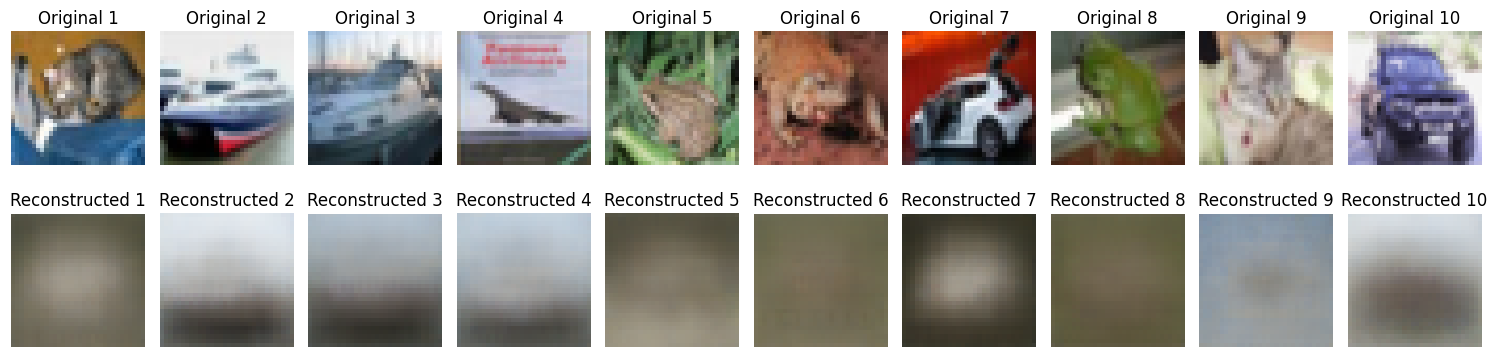

In [6]:
# =============================================================================
# 5. QUESTION 1A: LATENT DIMENSION = 2
# =============================================================================

print("=" * 70)
print("QUESTION 1A: Latent Dimension = 2")
print("=" * 70)

# Initialize model with latent dimension 2
model_2d = BetaVAE(latent_dim=2, beta=1.0).to(device)
print(f"Model initialized with latent dimension: 2")

# Train the model
print("Training model with latent dimension 2...")
train_losses_2d, test_losses_2d = train_vae(model_2d, train_loader, test_loader, epochs=30)

# Plot training losses
plot_training_loss(train_losses_2d, test_losses_2d)

# Display reconstructions
print("\nDisplaying original vs reconstructed images (latent dim = 2):")
plot_reconstructions(model_2d, test_loader, num_images=10)

COMPARISON: Latent Dimension = 100
Model initialized with latent dimension: 100
Training model with latent dimension 100...


Epoch 1/30: 100%|██████████| 391/391 [00:11<00:00, 35.25it/s]


Epoch 1: Train Loss = 1946.9418 (BCE: 1928.6323, KLD: 18.3095), Test Loss = 1888.4673


Epoch 2/30: 100%|██████████| 391/391 [00:10<00:00, 35.87it/s]


Epoch 2: Train Loss = 1866.7157 (BCE: 1842.9263, KLD: 23.7894), Test Loss = 1854.7645


Epoch 3/30: 100%|██████████| 391/391 [00:10<00:00, 36.15it/s]


Epoch 3: Train Loss = 1846.9011 (BCE: 1820.6998, KLD: 26.2013), Test Loss = 1846.4887


Epoch 4/30: 100%|██████████| 391/391 [00:10<00:00, 35.85it/s]


Epoch 4: Train Loss = 1841.3428 (BCE: 1813.1440, KLD: 28.1988), Test Loss = 1843.0221


Epoch 5/30: 100%|██████████| 391/391 [00:10<00:00, 35.66it/s]


Epoch 5: Train Loss = 1837.4783 (BCE: 1807.7679, KLD: 29.7104), Test Loss = 1839.2258


Epoch 6/30: 100%|██████████| 391/391 [00:10<00:00, 35.69it/s]


Epoch 6: Train Loss = 1833.8985 (BCE: 1802.8807, KLD: 31.0178), Test Loss = 1835.5623


Epoch 7/30: 100%|██████████| 391/391 [00:10<00:00, 36.11it/s]


Epoch 7: Train Loss = 1831.1805 (BCE: 1798.7828, KLD: 32.3977), Test Loss = 1834.2621


Epoch 8/30: 100%|██████████| 391/391 [00:10<00:00, 36.29it/s]


Epoch 8: Train Loss = 1829.3423 (BCE: 1796.1803, KLD: 33.1620), Test Loss = 1832.0142


Epoch 9/30: 100%|██████████| 391/391 [00:10<00:00, 35.81it/s]


Epoch 9: Train Loss = 1827.7290 (BCE: 1793.8641, KLD: 33.8649), Test Loss = 1829.7971


Epoch 10/30: 100%|██████████| 391/391 [00:10<00:00, 35.61it/s]


Epoch 10: Train Loss = 1826.6764 (BCE: 1792.2956, KLD: 34.3808), Test Loss = 1830.1602


Epoch 11/30: 100%|██████████| 391/391 [00:10<00:00, 35.62it/s]


Epoch 11: Train Loss = 1825.8328 (BCE: 1790.8324, KLD: 35.0005), Test Loss = 1828.4063


Epoch 12/30: 100%|██████████| 391/391 [00:10<00:00, 35.93it/s]


Epoch 12: Train Loss = 1824.6343 (BCE: 1789.0498, KLD: 35.5845), Test Loss = 1828.6859


Epoch 13/30: 100%|██████████| 391/391 [00:10<00:00, 36.13it/s]


Epoch 13: Train Loss = 1823.9013 (BCE: 1787.7743, KLD: 36.1270), Test Loss = 1826.8905


Epoch 14/30: 100%|██████████| 391/391 [00:10<00:00, 36.04it/s]


Epoch 14: Train Loss = 1823.3240 (BCE: 1786.8470, KLD: 36.4769), Test Loss = 1827.1577


Epoch 15/30: 100%|██████████| 391/391 [00:10<00:00, 35.80it/s]


Epoch 15: Train Loss = 1822.5283 (BCE: 1785.6865, KLD: 36.8418), Test Loss = 1825.8190


Epoch 16/30: 100%|██████████| 391/391 [00:10<00:00, 35.93it/s]


Epoch 16: Train Loss = 1822.1894 (BCE: 1785.1513, KLD: 37.0381), Test Loss = 1825.7518


Epoch 17/30: 100%|██████████| 391/391 [00:10<00:00, 35.97it/s]


Epoch 17: Train Loss = 1821.6546 (BCE: 1784.3898, KLD: 37.2647), Test Loss = 1824.9915


Epoch 18/30: 100%|██████████| 391/391 [00:10<00:00, 35.92it/s]


Epoch 18: Train Loss = 1821.4430 (BCE: 1783.8788, KLD: 37.5642), Test Loss = 1825.8299


Epoch 19/30: 100%|██████████| 391/391 [00:10<00:00, 35.76it/s]


Epoch 19: Train Loss = 1820.9414 (BCE: 1783.0528, KLD: 37.8886), Test Loss = 1824.4717


Epoch 20/30: 100%|██████████| 391/391 [00:10<00:00, 35.89it/s]


Epoch 20: Train Loss = 1820.5610 (BCE: 1782.4421, KLD: 38.1189), Test Loss = 1824.3947


Epoch 21/30: 100%|██████████| 391/391 [00:10<00:00, 36.38it/s]


Epoch 21: Train Loss = 1820.2614 (BCE: 1781.8923, KLD: 38.3692), Test Loss = 1823.3818


Epoch 22/30: 100%|██████████| 391/391 [00:10<00:00, 37.29it/s]


Epoch 22: Train Loss = 1819.7821 (BCE: 1781.2117, KLD: 38.5704), Test Loss = 1823.4145


Epoch 23/30: 100%|██████████| 391/391 [00:10<00:00, 37.17it/s]


Epoch 23: Train Loss = 1819.6449 (BCE: 1780.8447, KLD: 38.8003), Test Loss = 1825.6050


Epoch 24/30: 100%|██████████| 391/391 [00:10<00:00, 36.42it/s]


Epoch 24: Train Loss = 1819.3015 (BCE: 1780.3279, KLD: 38.9736), Test Loss = 1823.1352


Epoch 25/30: 100%|██████████| 391/391 [00:11<00:00, 35.27it/s]


Epoch 25: Train Loss = 1818.9061 (BCE: 1779.7282, KLD: 39.1779), Test Loss = 1822.9214


Epoch 26/30: 100%|██████████| 391/391 [00:11<00:00, 35.39it/s]


Epoch 26: Train Loss = 1818.7910 (BCE: 1779.4613, KLD: 39.3297), Test Loss = 1822.3633


Epoch 27/30: 100%|██████████| 391/391 [00:11<00:00, 35.36it/s]


Epoch 27: Train Loss = 1818.6515 (BCE: 1779.1064, KLD: 39.5452), Test Loss = 1822.2310


Epoch 28/30: 100%|██████████| 391/391 [00:10<00:00, 36.13it/s]


Epoch 28: Train Loss = 1818.3681 (BCE: 1778.6271, KLD: 39.7410), Test Loss = 1822.6593


Epoch 29/30: 100%|██████████| 391/391 [00:10<00:00, 35.93it/s]


Epoch 29: Train Loss = 1818.1773 (BCE: 1778.3361, KLD: 39.8412), Test Loss = 1821.7609


Epoch 30/30: 100%|██████████| 391/391 [00:10<00:00, 35.71it/s]


Epoch 30: Train Loss = 1818.0081 (BCE: 1778.0324, KLD: 39.9757), Test Loss = 1822.9201


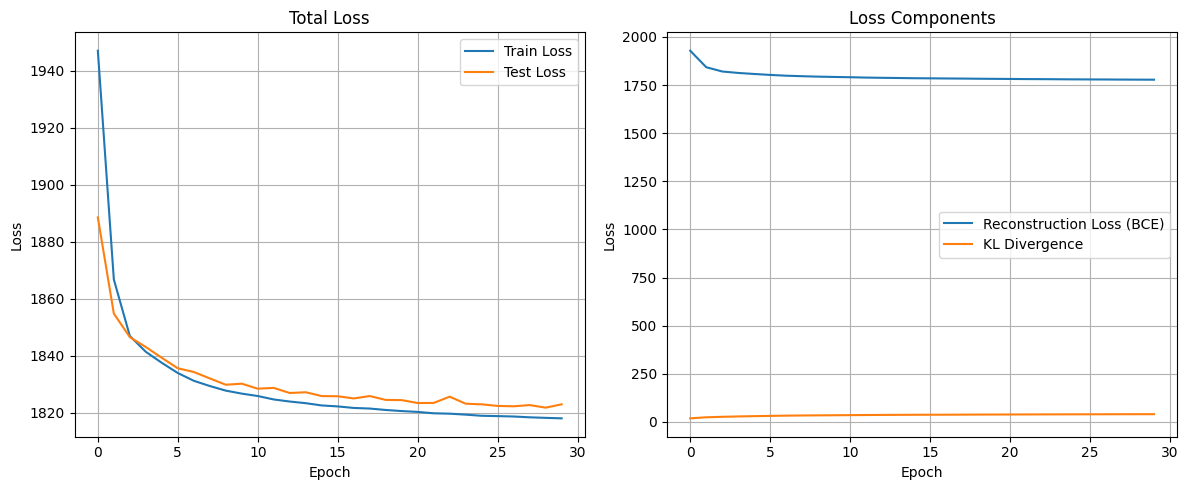


Displaying original vs reconstructed images (latent dim = 100):


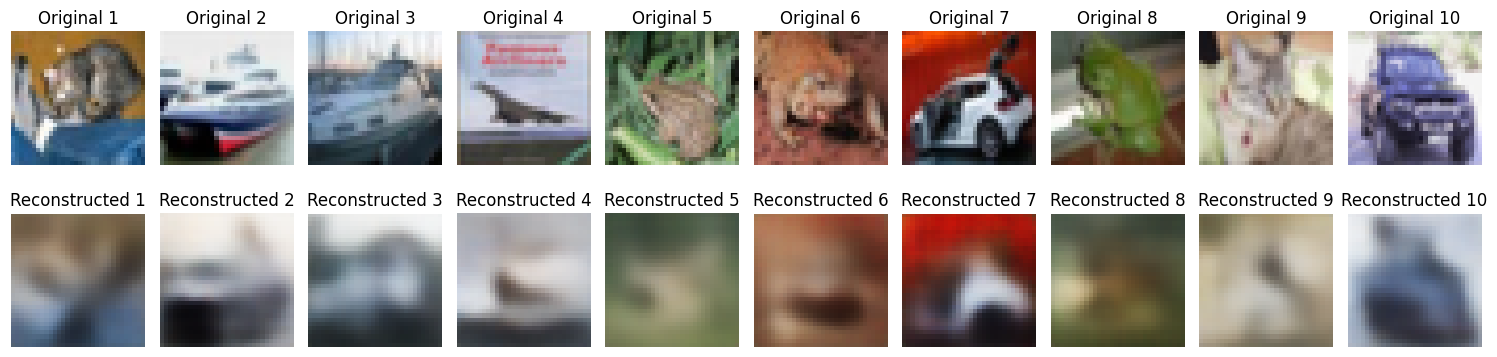


DISCUSSION: Latent Dimension Effect
The latent space dimension significantly affects reconstruction quality:
- Latent dim = 2: Limited capacity, poorer reconstruction
- Latent dim = 100: Higher capacity, better reconstruction
This demonstrates the trade-off between compression and reconstruction fidelity.


In [7]:
# =============================================================================
# COMPARISON: LATENT DIMENSION = 100
# =============================================================================

print("=" * 70)
print("COMPARISON: Latent Dimension = 100")
print("=" * 70)

# Initialize model with latent dimension 100
model_100d = BetaVAE(latent_dim=100, beta=1.0).to(device)
print(f"Model initialized with latent dimension: 100")

# Train the model
print("Training model with latent dimension 100...")
train_losses_100d, test_losses_100d = train_vae(model_100d, train_loader, test_loader, epochs=30)

# Plot training losses
plot_training_loss(train_losses_100d, test_losses_100d)

# Display reconstructions
print("\nDisplaying original vs reconstructed images (latent dim = 100):")
plot_reconstructions(model_100d, test_loader, num_images=10)

print("\n" + "="*50)
print("DISCUSSION: Latent Dimension Effect")
print("="*50)
print("The latent space dimension significantly affects reconstruction quality:")
print("- Latent dim = 2: Limited capacity, poorer reconstruction")
print("- Latent dim = 100: Higher capacity, better reconstruction")
print("This demonstrates the trade-off between compression and reconstruction fidelity.")

QUESTION 1B: β-Value Experiments

Training with β = 0.1


Epoch 1/30: 100%|██████████| 391/391 [00:10<00:00, 36.61it/s]


Epoch 1: Train Loss = 1917.8628 (BCE: 1910.8218, KLD: 70.4099), Test Loss = 1857.4406


Epoch 2/30: 100%|██████████| 391/391 [00:10<00:00, 36.28it/s]


Epoch 2: Train Loss = 1824.8776 (BCE: 1815.2387, KLD: 96.3886), Test Loss = 1816.2875


Epoch 3/30: 100%|██████████| 391/391 [00:10<00:00, 36.48it/s]


Epoch 3: Train Loss = 1803.0985 (BCE: 1793.1152, KLD: 99.8332), Test Loss = 1797.6495


Epoch 4/30: 100%|██████████| 391/391 [00:10<00:00, 36.05it/s]


Epoch 4: Train Loss = 1791.2555 (BCE: 1781.0091, KLD: 102.4634), Test Loss = 1791.0645


Epoch 5/30: 100%|██████████| 391/391 [00:10<00:00, 36.45it/s]


Epoch 5: Train Loss = 1783.2718 (BCE: 1772.7959, KLD: 104.7588), Test Loss = 1782.0965


Epoch 6/30: 100%|██████████| 391/391 [00:10<00:00, 36.24it/s]


Epoch 6: Train Loss = 1775.9579 (BCE: 1765.0791, KLD: 108.7878), Test Loss = 1775.8498


Epoch 7/30: 100%|██████████| 391/391 [00:10<00:00, 36.37it/s]


Epoch 7: Train Loss = 1771.0670 (BCE: 1759.9496, KLD: 111.1747), Test Loss = 1770.9696


Epoch 8/30: 100%|██████████| 391/391 [00:10<00:00, 35.88it/s]


Epoch 8: Train Loss = 1766.8531 (BCE: 1755.5012, KLD: 113.5187), Test Loss = 1768.3129


Epoch 9/30: 100%|██████████| 391/391 [00:10<00:00, 36.00it/s]


Epoch 9: Train Loss = 1764.1734 (BCE: 1752.5424, KLD: 116.3104), Test Loss = 1766.3807


Epoch 10/30: 100%|██████████| 391/391 [00:10<00:00, 35.83it/s]


Epoch 10: Train Loss = 1762.2269 (BCE: 1750.3485, KLD: 118.7836), Test Loss = 1768.0093


Epoch 11/30: 100%|██████████| 391/391 [00:10<00:00, 36.30it/s]


Epoch 11: Train Loss = 1759.8835 (BCE: 1747.7557, KLD: 121.2777), Test Loss = 1762.9167


Epoch 12/30: 100%|██████████| 391/391 [00:10<00:00, 35.98it/s]


Epoch 12: Train Loss = 1758.4146 (BCE: 1745.9940, KLD: 124.2051), Test Loss = 1761.5027


Epoch 13/30: 100%|██████████| 391/391 [00:10<00:00, 36.12it/s]


Epoch 13: Train Loss = 1757.1053 (BCE: 1744.5244, KLD: 125.8096), Test Loss = 1759.2433


Epoch 14/30: 100%|██████████| 391/391 [00:10<00:00, 36.36it/s]


Epoch 14: Train Loss = 1755.8327 (BCE: 1743.0992, KLD: 127.3356), Test Loss = 1758.4276


Epoch 15/30: 100%|██████████| 391/391 [00:10<00:00, 35.91it/s]


Epoch 15: Train Loss = 1754.8153 (BCE: 1741.9083, KLD: 129.0704), Test Loss = 1757.7187


Epoch 16/30: 100%|██████████| 391/391 [00:10<00:00, 35.98it/s]


Epoch 16: Train Loss = 1753.9159 (BCE: 1740.8403, KLD: 130.7560), Test Loss = 1756.5867


Epoch 17/30: 100%|██████████| 391/391 [00:10<00:00, 36.34it/s]


Epoch 17: Train Loss = 1752.9464 (BCE: 1739.7030, KLD: 132.4340), Test Loss = 1756.5395


Epoch 18/30: 100%|██████████| 391/391 [00:10<00:00, 36.28it/s]


Epoch 18: Train Loss = 1752.2502 (BCE: 1738.9016, KLD: 133.4860), Test Loss = 1755.5954


Epoch 19/30: 100%|██████████| 391/391 [00:10<00:00, 36.38it/s]


Epoch 19: Train Loss = 1751.9914 (BCE: 1738.5229, KLD: 134.6844), Test Loss = 1755.0188


Epoch 20/30: 100%|██████████| 391/391 [00:10<00:00, 36.26it/s]


Epoch 20: Train Loss = 1751.2889 (BCE: 1737.6965, KLD: 135.9241), Test Loss = 1756.6548


Epoch 21/30: 100%|██████████| 391/391 [00:10<00:00, 36.29it/s]


Epoch 21: Train Loss = 1750.5399 (BCE: 1736.7635, KLD: 137.7637), Test Loss = 1753.5410


Epoch 22/30: 100%|██████████| 391/391 [00:10<00:00, 36.08it/s]


Epoch 22: Train Loss = 1749.9557 (BCE: 1735.9823, KLD: 139.7339), Test Loss = 1753.5955


Epoch 23/30: 100%|██████████| 391/391 [00:10<00:00, 36.40it/s]


Epoch 23: Train Loss = 1749.6013 (BCE: 1735.4875, KLD: 141.1371), Test Loss = 1754.7672


Epoch 24/30: 100%|██████████| 391/391 [00:10<00:00, 36.23it/s]


Epoch 24: Train Loss = 1748.8977 (BCE: 1734.6152, KLD: 142.8250), Test Loss = 1752.0817


Epoch 25/30: 100%|██████████| 391/391 [00:10<00:00, 36.35it/s]


Epoch 25: Train Loss = 1748.2440 (BCE: 1733.8201, KLD: 144.2390), Test Loss = 1751.5895


Epoch 26/30: 100%|██████████| 391/391 [00:10<00:00, 36.01it/s]


Epoch 26: Train Loss = 1748.0229 (BCE: 1733.5041, KLD: 145.1883), Test Loss = 1751.1511


Epoch 27/30: 100%|██████████| 391/391 [00:10<00:00, 35.79it/s]


Epoch 27: Train Loss = 1747.4356 (BCE: 1732.8387, KLD: 145.9695), Test Loss = 1750.8732


Epoch 28/30: 100%|██████████| 391/391 [00:10<00:00, 36.08it/s]


Epoch 28: Train Loss = 1747.3848 (BCE: 1732.7427, KLD: 146.4215), Test Loss = 1751.1034


Epoch 29/30: 100%|██████████| 391/391 [00:10<00:00, 35.97it/s]


Epoch 29: Train Loss = 1746.9345 (BCE: 1732.2330, KLD: 147.0150), Test Loss = 1753.8981


Epoch 30/30: 100%|██████████| 391/391 [00:10<00:00, 36.06it/s]


Epoch 30: Train Loss = 1746.6886 (BCE: 1731.9088, KLD: 147.7979), Test Loss = 1749.8074

Generated images with β = 0.1:


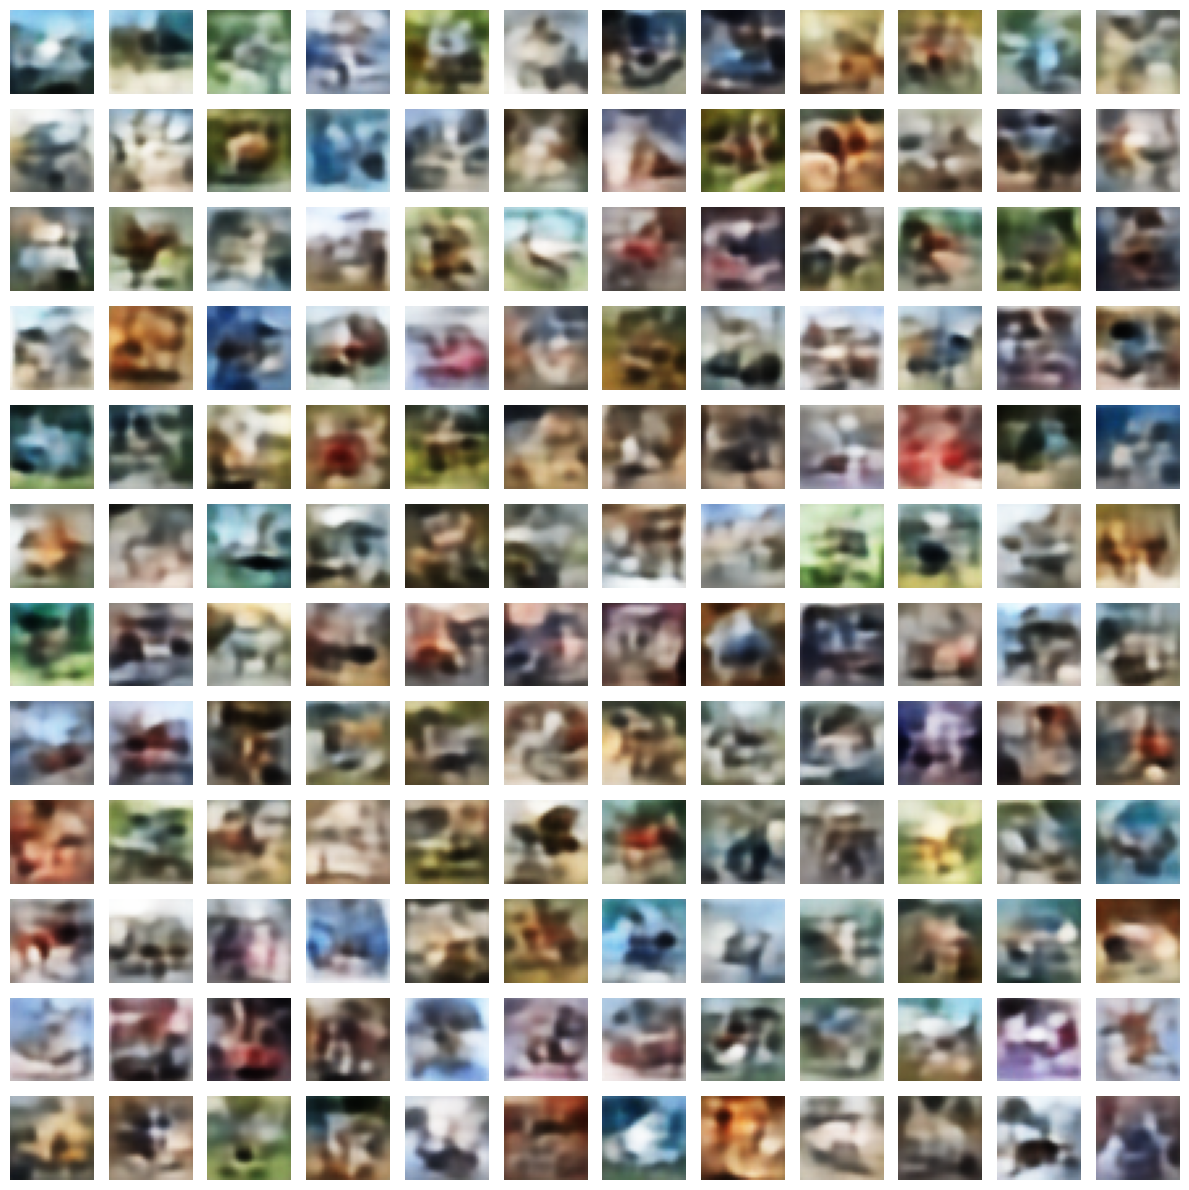


Training with β = 1.0


Epoch 1/30: 100%|██████████| 391/391 [00:11<00:00, 34.32it/s]


Epoch 1: Train Loss = 1944.8670 (BCE: 1926.4259, KLD: 18.4411), Test Loss = 1884.1160


Epoch 2/30: 100%|██████████| 391/391 [00:11<00:00, 33.66it/s]


Epoch 2: Train Loss = 1866.8093 (BCE: 1843.6666, KLD: 23.1427), Test Loss = 1857.1609


Epoch 3/30: 100%|██████████| 391/391 [00:11<00:00, 33.68it/s]


Epoch 3: Train Loss = 1849.4527 (BCE: 1823.1701, KLD: 26.2827), Test Loss = 1847.1797


Epoch 4/30: 100%|██████████| 391/391 [00:11<00:00, 33.26it/s]


Epoch 4: Train Loss = 1841.8441 (BCE: 1813.3797, KLD: 28.4644), Test Loss = 1842.5568


Epoch 5/30: 100%|██████████| 391/391 [00:11<00:00, 33.73it/s]


Epoch 5: Train Loss = 1837.4065 (BCE: 1807.7267, KLD: 29.6798), Test Loss = 1840.7284


Epoch 6/30: 100%|██████████| 391/391 [00:11<00:00, 33.42it/s]


Epoch 6: Train Loss = 1834.3428 (BCE: 1803.5470, KLD: 30.7958), Test Loss = 1836.1015


Epoch 7/30: 100%|██████████| 391/391 [00:11<00:00, 33.72it/s]


Epoch 7: Train Loss = 1831.8160 (BCE: 1799.6157, KLD: 32.2002), Test Loss = 1833.2413


Epoch 8/30: 100%|██████████| 391/391 [00:11<00:00, 33.86it/s]


Epoch 8: Train Loss = 1830.1104 (BCE: 1797.1331, KLD: 32.9773), Test Loss = 1833.5833


Epoch 9/30: 100%|██████████| 391/391 [00:11<00:00, 33.28it/s]


Epoch 9: Train Loss = 1828.8636 (BCE: 1795.3744, KLD: 33.4892), Test Loss = 1831.3401


Epoch 10/30: 100%|██████████| 391/391 [00:11<00:00, 33.48it/s]


Epoch 10: Train Loss = 1827.5850 (BCE: 1793.5712, KLD: 34.0138), Test Loss = 1830.0282


Epoch 11/30: 100%|██████████| 391/391 [00:11<00:00, 33.41it/s]


Epoch 11: Train Loss = 1826.4856 (BCE: 1791.8127, KLD: 34.6730), Test Loss = 1829.3596


Epoch 12/30: 100%|██████████| 391/391 [00:11<00:00, 33.86it/s]


Epoch 12: Train Loss = 1825.6648 (BCE: 1790.3846, KLD: 35.2802), Test Loss = 1828.9731


Epoch 13/30: 100%|██████████| 391/391 [00:11<00:00, 33.70it/s]


Epoch 13: Train Loss = 1824.4498 (BCE: 1788.5202, KLD: 35.9296), Test Loss = 1829.5103


Epoch 14/30: 100%|██████████| 391/391 [00:11<00:00, 33.43it/s]


Epoch 14: Train Loss = 1823.9207 (BCE: 1787.6704, KLD: 36.2503), Test Loss = 1826.7839


Epoch 15/30: 100%|██████████| 391/391 [00:11<00:00, 34.66it/s]


Epoch 15: Train Loss = 1823.3034 (BCE: 1786.8088, KLD: 36.4946), Test Loss = 1827.2427


Epoch 16/30: 100%|██████████| 391/391 [00:11<00:00, 34.29it/s]


Epoch 16: Train Loss = 1822.6791 (BCE: 1785.8092, KLD: 36.8699), Test Loss = 1827.2450


Epoch 17/30: 100%|██████████| 391/391 [00:11<00:00, 33.72it/s]


Epoch 17: Train Loss = 1822.1210 (BCE: 1784.8812, KLD: 37.2399), Test Loss = 1825.9323


Epoch 18/30: 100%|██████████| 391/391 [00:11<00:00, 33.13it/s]


Epoch 18: Train Loss = 1821.6286 (BCE: 1784.0005, KLD: 37.6281), Test Loss = 1824.8643


Epoch 19/30: 100%|██████████| 391/391 [00:11<00:00, 33.54it/s]


Epoch 19: Train Loss = 1821.0176 (BCE: 1783.1096, KLD: 37.9080), Test Loss = 1824.8594


Epoch 20/30: 100%|██████████| 391/391 [00:11<00:00, 33.67it/s]


Epoch 20: Train Loss = 1820.7001 (BCE: 1782.5175, KLD: 38.1825), Test Loss = 1824.3425


Epoch 21/30: 100%|██████████| 391/391 [00:11<00:00, 32.88it/s]


Epoch 21: Train Loss = 1820.7201 (BCE: 1782.3801, KLD: 38.3399), Test Loss = 1824.5767


Epoch 22/30: 100%|██████████| 391/391 [00:11<00:00, 33.42it/s]


Epoch 22: Train Loss = 1820.3990 (BCE: 1781.9239, KLD: 38.4751), Test Loss = 1823.8239


Epoch 23/30: 100%|██████████| 391/391 [00:11<00:00, 33.68it/s]


Epoch 23: Train Loss = 1819.9465 (BCE: 1781.3247, KLD: 38.6218), Test Loss = 1824.0032


Epoch 24/30: 100%|██████████| 391/391 [00:11<00:00, 33.28it/s]


Epoch 24: Train Loss = 1819.6865 (BCE: 1780.8587, KLD: 38.8278), Test Loss = 1823.7232


Epoch 25/30: 100%|██████████| 391/391 [00:11<00:00, 33.57it/s]


Epoch 25: Train Loss = 1819.3910 (BCE: 1780.3330, KLD: 39.0580), Test Loss = 1823.7120


Epoch 26/30: 100%|██████████| 391/391 [00:11<00:00, 33.91it/s]


Epoch 26: Train Loss = 1819.1709 (BCE: 1779.9434, KLD: 39.2275), Test Loss = 1823.2011


Epoch 27/30: 100%|██████████| 391/391 [00:11<00:00, 33.75it/s]


Epoch 27: Train Loss = 1818.9669 (BCE: 1779.5487, KLD: 39.4181), Test Loss = 1823.0313


Epoch 28/30: 100%|██████████| 391/391 [00:11<00:00, 33.78it/s]


Epoch 28: Train Loss = 1818.6449 (BCE: 1779.0540, KLD: 39.5909), Test Loss = 1822.8977


Epoch 29/30: 100%|██████████| 391/391 [00:11<00:00, 34.04it/s]


Epoch 29: Train Loss = 1818.4866 (BCE: 1778.8054, KLD: 39.6812), Test Loss = 1822.8605


Epoch 30/30: 100%|██████████| 391/391 [00:11<00:00, 34.54it/s]


Epoch 30: Train Loss = 1818.4311 (BCE: 1778.6272, KLD: 39.8040), Test Loss = 1822.2322

Generated images with β = 1.0:


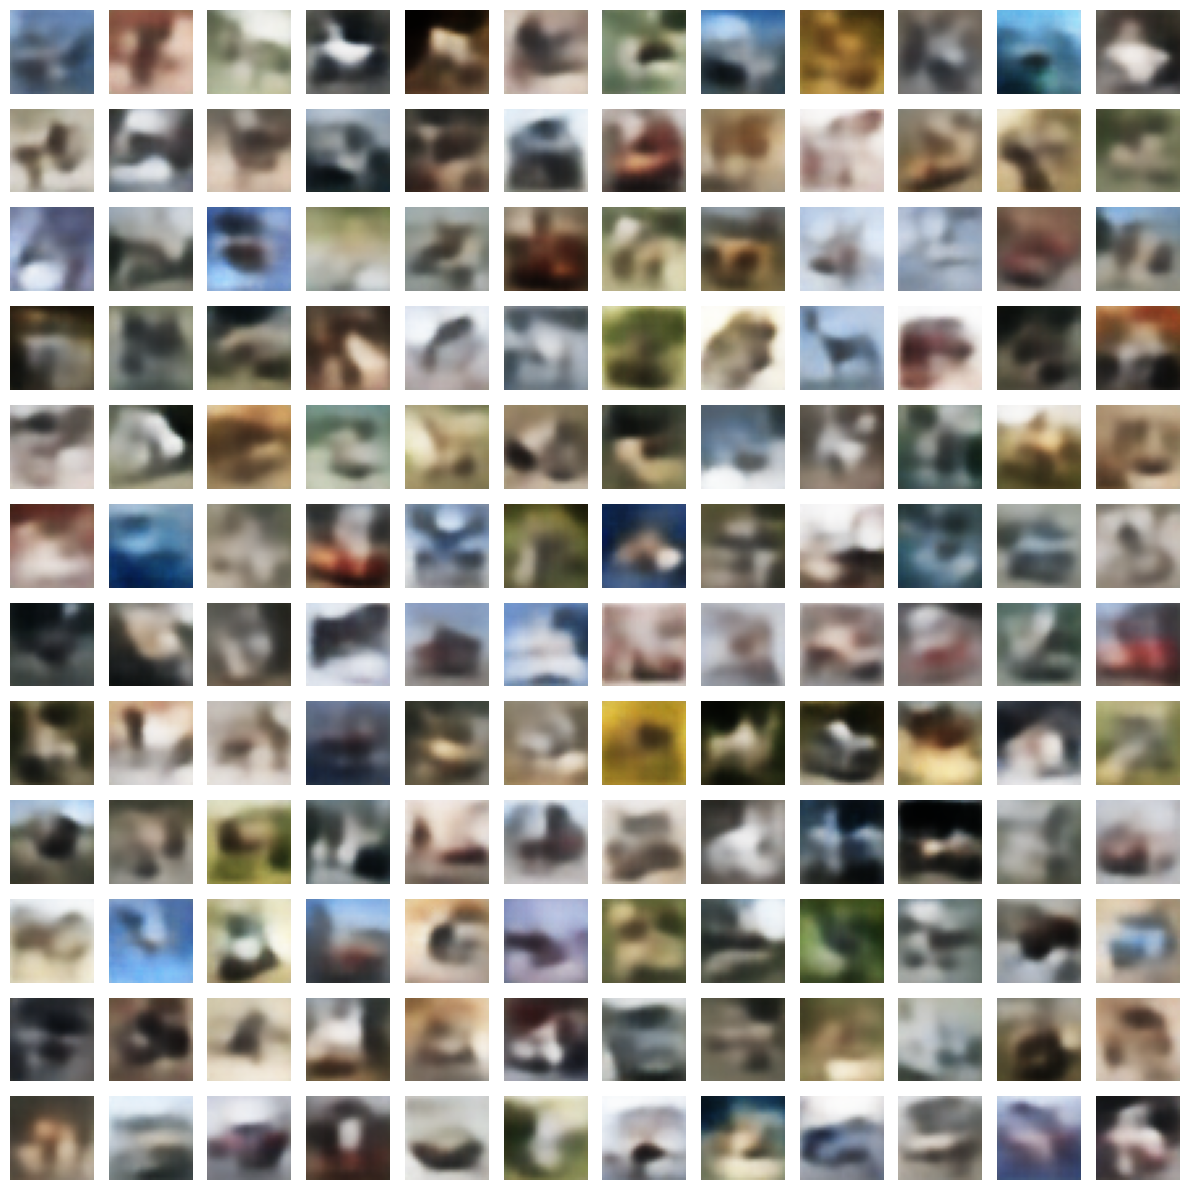


Training with β = 5.0


Epoch 1/30: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]


Epoch 1: Train Loss = 1999.4077 (BCE: 1970.7787, KLD: 5.7258), Test Loss = 1945.5029


Epoch 2/30: 100%|██████████| 391/391 [00:12<00:00, 31.38it/s]


Epoch 2: Train Loss = 1935.5891 (BCE: 1896.0014, KLD: 7.9175), Test Loss = 1934.2229


Epoch 3/30: 100%|██████████| 391/391 [00:12<00:00, 31.39it/s]


Epoch 3: Train Loss = 1927.7004 (BCE: 1883.3901, KLD: 8.8621), Test Loss = 1926.3700


Epoch 4/30: 100%|██████████| 391/391 [00:12<00:00, 30.63it/s]


Epoch 4: Train Loss = 1920.8882 (BCE: 1872.7998, KLD: 9.6177), Test Loss = 1920.3166


Epoch 5/30: 100%|██████████| 391/391 [00:13<00:00, 29.77it/s]


Epoch 5: Train Loss = 1916.7510 (BCE: 1866.5263, KLD: 10.0449), Test Loss = 1917.9574


Epoch 6/30: 100%|██████████| 391/391 [00:13<00:00, 29.90it/s]


Epoch 6: Train Loss = 1914.3418 (BCE: 1862.2103, KLD: 10.4263), Test Loss = 1917.4793


Epoch 7/30: 100%|██████████| 391/391 [00:12<00:00, 30.91it/s]


Epoch 7: Train Loss = 1913.2475 (BCE: 1860.0976, KLD: 10.6300), Test Loss = 1915.4159


Epoch 8/30: 100%|██████████| 391/391 [00:12<00:00, 30.33it/s]


Epoch 8: Train Loss = 1912.3346 (BCE: 1858.7288, KLD: 10.7212), Test Loss = 1914.3346


Epoch 9/30: 100%|██████████| 391/391 [00:13<00:00, 29.89it/s]


Epoch 9: Train Loss = 1911.3276 (BCE: 1856.9748, KLD: 10.8706), Test Loss = 1913.9915


Epoch 10/30: 100%|██████████| 391/391 [00:12<00:00, 30.73it/s]


Epoch 10: Train Loss = 1910.9401 (BCE: 1856.0699, KLD: 10.9740), Test Loss = 1913.3513


Epoch 11/30: 100%|██████████| 391/391 [00:12<00:00, 30.25it/s]


Epoch 11: Train Loss = 1909.9787 (BCE: 1854.8072, KLD: 11.0343), Test Loss = 1912.7563


Epoch 12/30: 100%|██████████| 391/391 [00:12<00:00, 30.23it/s]


Epoch 12: Train Loss = 1909.6946 (BCE: 1854.3120, KLD: 11.0765), Test Loss = 1912.6794


Epoch 13/30: 100%|██████████| 391/391 [00:13<00:00, 30.04it/s]


Epoch 13: Train Loss = 1909.5469 (BCE: 1853.9794, KLD: 11.1135), Test Loss = 1912.7440


Epoch 14/30: 100%|██████████| 391/391 [00:12<00:00, 30.25it/s]


Epoch 14: Train Loss = 1909.4753 (BCE: 1853.8911, KLD: 11.1168), Test Loss = 1913.8863


Epoch 15/30: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]


Epoch 15: Train Loss = 1909.0103 (BCE: 1853.2244, KLD: 11.1572), Test Loss = 1911.2309


Epoch 16/30: 100%|██████████| 391/391 [00:12<00:00, 30.22it/s]


Epoch 16: Train Loss = 1908.5110 (BCE: 1852.4931, KLD: 11.2036), Test Loss = 1911.5754


Epoch 17/30: 100%|██████████| 391/391 [00:12<00:00, 31.00it/s]


Epoch 17: Train Loss = 1908.2739 (BCE: 1852.0339, KLD: 11.2480), Test Loss = 1911.2580


Epoch 18/30: 100%|██████████| 391/391 [00:12<00:00, 30.50it/s]


Epoch 18: Train Loss = 1908.0534 (BCE: 1851.5810, KLD: 11.2945), Test Loss = 1911.2911


Epoch 19/30: 100%|██████████| 391/391 [00:12<00:00, 30.36it/s]


Epoch 19: Train Loss = 1907.9250 (BCE: 1851.1462, KLD: 11.3558), Test Loss = 1910.9409


Epoch 20/30: 100%|██████████| 391/391 [00:12<00:00, 30.31it/s]


Epoch 20: Train Loss = 1907.7331 (BCE: 1850.7168, KLD: 11.4032), Test Loss = 1912.0067


Epoch 21/30: 100%|██████████| 391/391 [00:12<00:00, 30.71it/s]


Epoch 21: Train Loss = 1907.4858 (BCE: 1850.4725, KLD: 11.4027), Test Loss = 1911.7534


Epoch 22/30: 100%|██████████| 391/391 [00:13<00:00, 30.03it/s]


Epoch 22: Train Loss = 1907.1390 (BCE: 1849.9450, KLD: 11.4388), Test Loss = 1911.9239


Epoch 23/30: 100%|██████████| 391/391 [00:12<00:00, 30.56it/s]


Epoch 23: Train Loss = 1907.1891 (BCE: 1849.7230, KLD: 11.4932), Test Loss = 1911.4340


Epoch 24/30: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]


Epoch 24: Train Loss = 1906.6406 (BCE: 1849.0589, KLD: 11.5163), Test Loss = 1910.4917


Epoch 25/30: 100%|██████████| 391/391 [00:12<00:00, 31.04it/s]


Epoch 25: Train Loss = 1906.5656 (BCE: 1848.7469, KLD: 11.5638), Test Loss = 1909.9167


Epoch 26/30: 100%|██████████| 391/391 [00:12<00:00, 30.85it/s]


Epoch 26: Train Loss = 1906.5142 (BCE: 1848.4525, KLD: 11.6123), Test Loss = 1910.9441


Epoch 27/30: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]


Epoch 27: Train Loss = 1906.3218 (BCE: 1848.2763, KLD: 11.6091), Test Loss = 1909.9693


Epoch 28/30: 100%|██████████| 391/391 [00:12<00:00, 30.79it/s]


Epoch 28: Train Loss = 1906.2517 (BCE: 1848.0476, KLD: 11.6408), Test Loss = 1910.6859


Epoch 29/30: 100%|██████████| 391/391 [00:12<00:00, 30.88it/s]


Epoch 29: Train Loss = 1906.0376 (BCE: 1847.7170, KLD: 11.6641), Test Loss = 1909.6709


Epoch 30/30: 100%|██████████| 391/391 [00:12<00:00, 30.71it/s]


Epoch 30: Train Loss = 1905.8507 (BCE: 1847.6162, KLD: 11.6469), Test Loss = 1910.2912

Generated images with β = 5.0:


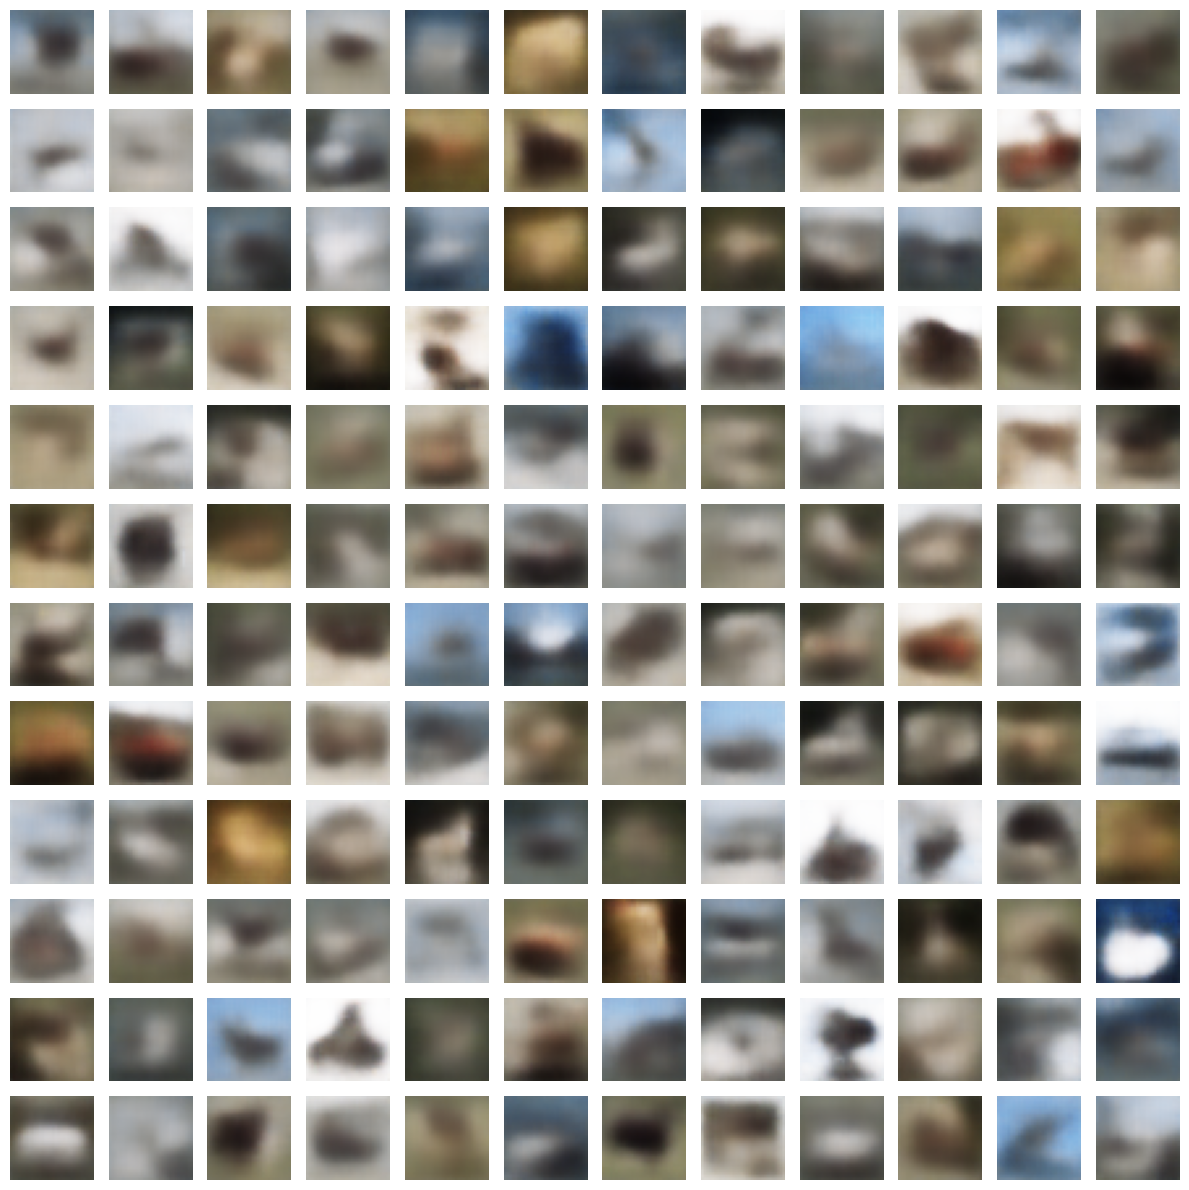


Original CIFAR-10 images for reference:


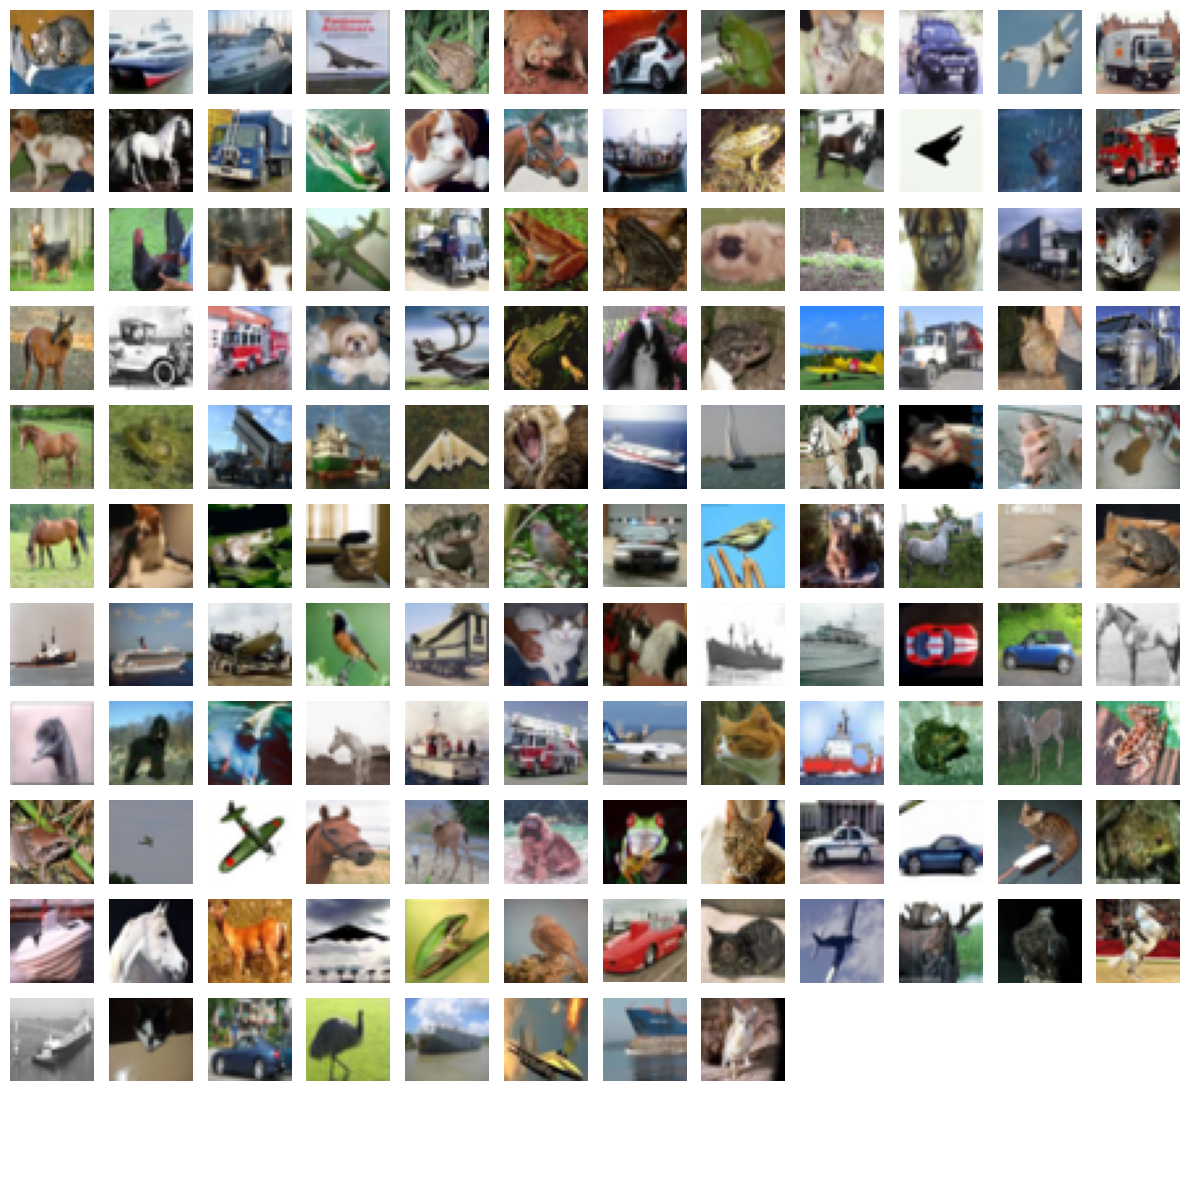

In [8]:
# =============================================================================
# 6. QUESTION 1B: β-VALUE EXPERIMENTS
# =============================================================================

print("=" * 70)
print("QUESTION 1B: β-Value Experiments")
print("=" * 70)

# Define β values to test
beta_values = [0.1, 1.0, 5.0]  # β < 1, β = 1, β > 1
models = {}

for beta in beta_values:
    print(f"\n{'='*40}")
    print(f"Training with β = {beta}")
    print(f"{'='*40}")

    # Initialize and train model
    model = BetaVAE(latent_dim=100, beta=beta).to(device)
    train_losses, test_losses = train_vae(model, train_loader, test_loader, epochs=30)
    models[beta] = model

    # Plot grid of generated images
    print(f"\nGenerated images with β = {beta}:")
    plot_latent_space_grid(model, grid_size=12, latent_dim=100)

# Display original images for comparison
print("\nOriginal CIFAR-10 images for reference:")
data_iter = iter(test_loader)
original_images, _ = next(data_iter)
fig, axes = plt.subplots(12, 12, figsize=(12, 12))
for i in range(144):
    row, col = i // 12, i % 12
    if i < len(original_images):
        axes[row, col].imshow(original_images[i].permute(1, 2, 0))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

QUESTION 1C: Excessive Regularization (High β)
Training with excessive β = 50.0...


Epoch 1/30: 100%|██████████| 391/391 [00:10<00:00, 35.81it/s]


Epoch 1: Train Loss = 2094.2502 (BCE: 2065.6785, KLD: 0.5714), Test Loss = 2084.7841


Epoch 2/30: 100%|██████████| 391/391 [00:10<00:00, 35.98it/s]


Epoch 2: Train Loss = 2077.1998 (BCE: 2035.7436, KLD: 0.8291), Test Loss = 2066.1394


Epoch 3/30: 100%|██████████| 391/391 [00:10<00:00, 36.00it/s]


Epoch 3: Train Loss = 2062.6203 (BCE: 2014.1063, KLD: 0.9703), Test Loss = 2066.3978


Epoch 4/30: 100%|██████████| 391/391 [00:10<00:00, 35.87it/s]


Epoch 4: Train Loss = 2061.9329 (BCE: 2013.4793, KLD: 0.9691), Test Loss = 2061.6830


Epoch 5/30: 100%|██████████| 391/391 [00:10<00:00, 35.62it/s]


Epoch 5: Train Loss = 2061.5662 (BCE: 2012.8435, KLD: 0.9745), Test Loss = 2062.8865


Epoch 6/30: 100%|██████████| 391/391 [00:11<00:00, 35.23it/s]


Epoch 6: Train Loss = 2061.2351 (BCE: 2012.3304, KLD: 0.9781), Test Loss = 2068.7828


Epoch 7/30: 100%|██████████| 391/391 [00:10<00:00, 35.65it/s]


Epoch 7: Train Loss = 2061.3567 (BCE: 2012.2775, KLD: 0.9816), Test Loss = 2062.4619


Epoch 8/30: 100%|██████████| 391/391 [00:10<00:00, 35.62it/s]


Epoch 8: Train Loss = 2060.8889 (BCE: 2011.7758, KLD: 0.9823), Test Loss = 2062.3665


Epoch 9/30: 100%|██████████| 391/391 [00:10<00:00, 35.82it/s]


Epoch 9: Train Loss = 2060.3291 (BCE: 2009.9186, KLD: 1.0082), Test Loss = 2060.4160


Epoch 10/30: 100%|██████████| 391/391 [00:10<00:00, 35.68it/s]


Epoch 10: Train Loss = 2059.0269 (BCE: 2005.6837, KLD: 1.0669), Test Loss = 2059.2218


Epoch 11/30: 100%|██████████| 391/391 [00:10<00:00, 35.82it/s]


Epoch 11: Train Loss = 2058.5151 (BCE: 2004.0763, KLD: 1.0888), Test Loss = 2061.4987


Epoch 12/30: 100%|██████████| 391/391 [00:10<00:00, 35.95it/s]


Epoch 12: Train Loss = 2058.0795 (BCE: 2003.4775, KLD: 1.0920), Test Loss = 2058.7702


Epoch 13/30: 100%|██████████| 391/391 [00:10<00:00, 35.56it/s]


Epoch 13: Train Loss = 2057.9753 (BCE: 2003.3331, KLD: 1.0928), Test Loss = 2059.6329


Epoch 14/30: 100%|██████████| 391/391 [00:10<00:00, 35.57it/s]


Epoch 14: Train Loss = 2058.2211 (BCE: 2003.4004, KLD: 1.0964), Test Loss = 2060.0103


Epoch 15/30: 100%|██████████| 391/391 [00:11<00:00, 35.34it/s]


Epoch 15: Train Loss = 2058.3689 (BCE: 2003.5020, KLD: 1.0973), Test Loss = 2058.5109


Epoch 16/30: 100%|██████████| 391/391 [00:10<00:00, 36.10it/s]


Epoch 16: Train Loss = 2058.0147 (BCE: 2003.3349, KLD: 1.0936), Test Loss = 2059.6435


Epoch 17/30: 100%|██████████| 391/391 [00:10<00:00, 36.47it/s]


Epoch 17: Train Loss = 2058.3452 (BCE: 2003.1167, KLD: 1.1046), Test Loss = 2059.1888


Epoch 18/30: 100%|██████████| 391/391 [00:10<00:00, 36.99it/s]


Epoch 18: Train Loss = 2057.9757 (BCE: 2002.9251, KLD: 1.1010), Test Loss = 2059.4057


Epoch 19/30: 100%|██████████| 391/391 [00:10<00:00, 36.99it/s]


Epoch 19: Train Loss = 2058.0769 (BCE: 2002.9304, KLD: 1.1029), Test Loss = 2059.1291


Epoch 20/30: 100%|██████████| 391/391 [00:10<00:00, 36.83it/s]


Epoch 20: Train Loss = 2057.9773 (BCE: 2002.6521, KLD: 1.1065), Test Loss = 2058.4752


Epoch 21/30: 100%|██████████| 391/391 [00:10<00:00, 36.50it/s]


Epoch 21: Train Loss = 2057.8039 (BCE: 2002.5404, KLD: 1.1053), Test Loss = 2057.9553


Epoch 22/30: 100%|██████████| 391/391 [00:10<00:00, 35.67it/s]


Epoch 22: Train Loss = 2058.1816 (BCE: 2002.6076, KLD: 1.1115), Test Loss = 2059.9016


Epoch 23/30: 100%|██████████| 391/391 [00:10<00:00, 35.88it/s]


Epoch 23: Train Loss = 2057.4272 (BCE: 2002.2676, KLD: 1.1032), Test Loss = 2058.3856


Epoch 24/30: 100%|██████████| 391/391 [00:10<00:00, 35.81it/s]


Epoch 24: Train Loss = 2057.9745 (BCE: 2002.7729, KLD: 1.1040), Test Loss = 2058.5041


Epoch 25/30: 100%|██████████| 391/391 [00:10<00:00, 35.68it/s]


Epoch 25: Train Loss = 2057.4665 (BCE: 2002.1805, KLD: 1.1057), Test Loss = 2058.4960


Epoch 26/30: 100%|██████████| 391/391 [00:10<00:00, 35.71it/s]


Epoch 26: Train Loss = 2057.7846 (BCE: 2002.2902, KLD: 1.1099), Test Loss = 2061.5717


Epoch 27/30: 100%|██████████| 391/391 [00:10<00:00, 36.16it/s]


Epoch 27: Train Loss = 2057.5702 (BCE: 2002.3003, KLD: 1.1054), Test Loss = 2059.2889


Epoch 28/30: 100%|██████████| 391/391 [00:10<00:00, 35.90it/s]


Epoch 28: Train Loss = 2057.2002 (BCE: 2002.0626, KLD: 1.1028), Test Loss = 2058.8517


Epoch 29/30: 100%|██████████| 391/391 [00:11<00:00, 35.41it/s]


Epoch 29: Train Loss = 2057.5980 (BCE: 2002.0999, KLD: 1.1100), Test Loss = 2058.4480


Epoch 30/30: 100%|██████████| 391/391 [00:11<00:00, 35.50it/s]


Epoch 30: Train Loss = 2057.4354 (BCE: 2002.1102, KLD: 1.1065), Test Loss = 2059.1951


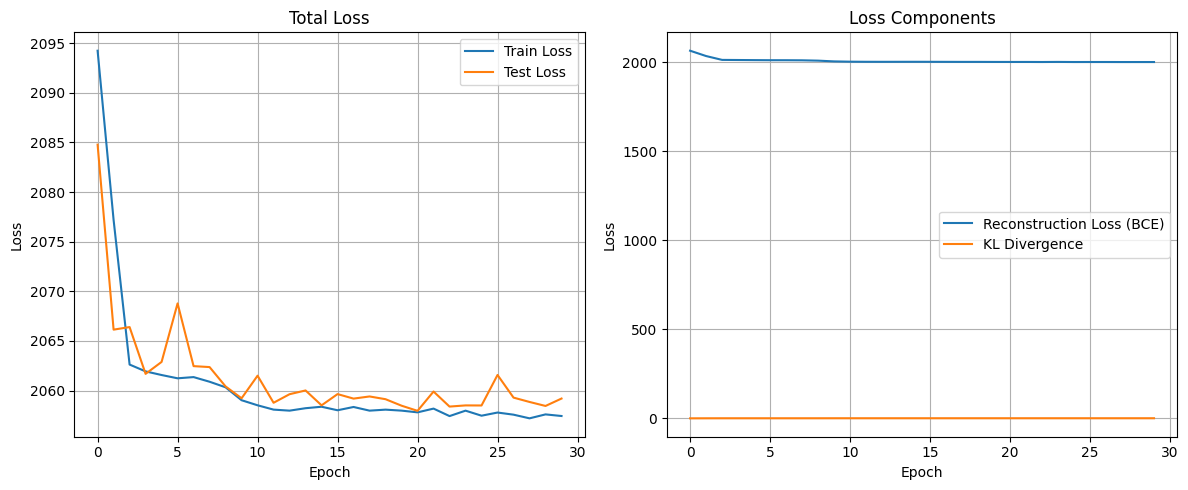


Generated images with excessive β = 50.0:


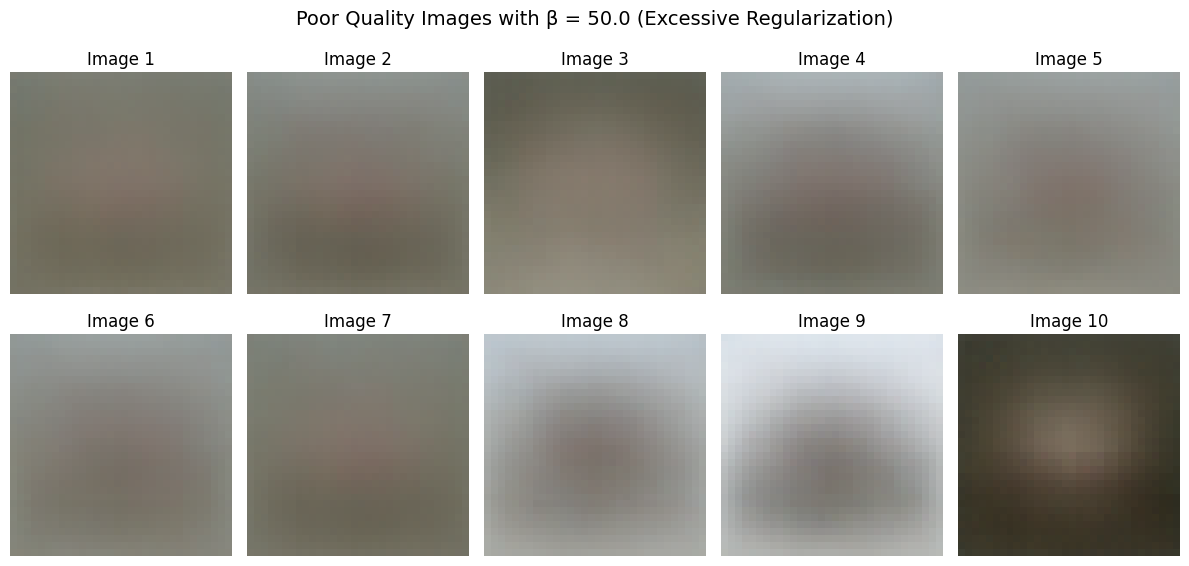


DISCUSSION: β-Value Effects
β < 1 (e.g., 0.1): Emphasizes reconstruction, less regularization
β = 1: Standard VAE, balanced reconstruction and regularization
β > 1 (e.g., 5.0): More regularization, better disentanglement
β >> 1 (e.g., 50.0): Excessive regularization, poor reconstruction
This demonstrates the trade-off between reconstruction quality and latent space regularization.


In [9]:
# =============================================================================
# 7. QUESTION 1C: EXCESSIVE REGULARIZATION
# =============================================================================

print("=" * 70)
print("QUESTION 1C: Excessive Regularization (High β)")
print("=" * 70)

# Train with very high β value
beta_excessive = 50.0  # Strong regularization
print(f"Training with excessive β = {beta_excessive}...")

model_excessive = BetaVAE(latent_dim=100, beta=beta_excessive).to(device)
train_losses_ex, test_losses_ex = train_vae(model_excessive, train_loader, test_loader, epochs=30)

# Plot training losses to show the effect
plot_training_loss(train_losses_ex, test_losses_ex)

# Generate and display poor quality images
print(f"\nGenerated images with excessive β = {beta_excessive}:")
model_excessive.eval()
with torch.no_grad():
    z = torch.randn(10, 100).to(device)
    poor_images = model_excessive.decode(z)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(poor_images[i].cpu().permute(1, 2, 0))
    ax.set_title(f"Image {i+1}")
    ax.axis('off')
plt.suptitle(f'Poor Quality Images with β = {beta_excessive} (Excessive Regularization)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("DISCUSSION: β-Value Effects")
print("="*50)
print("β < 1 (e.g., 0.1): Emphasizes reconstruction, less regularization")
print("β = 1: Standard VAE, balanced reconstruction and regularization")
print("β > 1 (e.g., 5.0): More regularization, better disentanglement")
print("β >> 1 (e.g., 50.0): Excessive regularization, poor reconstruction")
print("This demonstrates the trade-off between reconstruction quality and latent space regularization.")